
--- Transaction Class Distribution ---
Class
0    284315
1       492
Name: count, dtype: int64


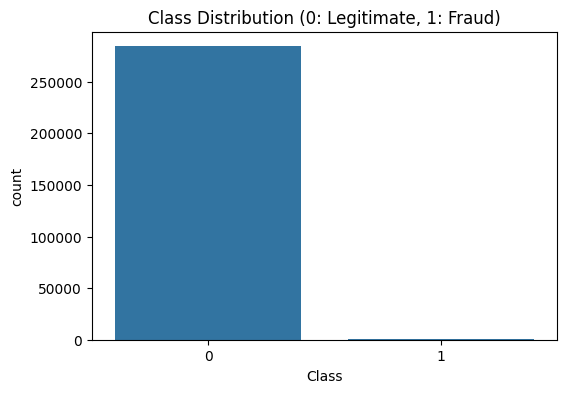

In [11]:
# Install necessary libraries (imbalanced-learn is crucial for SMOTE/NearMiss)
!pip install imbalanced-learn scikit-learn

# --- Imports ---
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load the Dataset
# NOTE: Ensure 'creditcard.csv' is uploaded to your Colab session files.
try:
    df = pd.read_csv('creditcard.csv')
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please upload it to your Colab environment.")
    exit()

# 2. Check for Imbalance (CRITICAL STEP)
fraud_count = df['Class'].value_counts()
print("\n--- Transaction Class Distribution ---")
print(fraud_count)

# Visualize Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')
plt.show()


In [12]:
# C. Data Preprocessing

# 1. Scaling 'Amount' and 'Time'
# RobustScaler is used for 'Amount' because it's less sensitive to outliers.
scaler = RobustScaler()
df['Amount_Scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# StandardScaler is used for 'Time'.
time_scaler = StandardScaler()
df['Time_Scaled'] = time_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 2. Drop the original unscaled columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 3. Define X (Features) and y (Target)
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Split the Data (70% Train, 30% Test)
# stratify=y is essential to ensure the tiny fraction of fraud cases is distributed evenly.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} | Fraud cases: {y_train.sum()}")
print(f"Test set size: {len(X_test)} | Fraud cases: {y_test.sum()}")


Training set size: 199364 | Fraud cases: 344
Test set size: 85443 | Fraud cases: 148


In [13]:
# D. Model 1 - Logistic Regression (SMOTE)

# 1. Apply SMOTE to the TRAINING data ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nSMOTE New Class Distribution: {y_train_smote.value_counts()}")

# 2. Train Model
model_LR = LogisticRegression(solver='liblinear', random_state=42)
model_LR.fit(X_train_smote, y_train_smote)

# 3. Predict & Evaluate on UNBALANCED Test Set
y_pred_LR = model_LR.predict(X_test)
y_proba_LR = model_LR.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression (SMOTE) Results ---")
print(classification_report(y_test, y_pred_LR))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_LR):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_LR))


SMOTE New Class Distribution: Class
0    199020
1    199020
Name: count, dtype: int64

--- Logistic Regression (SMOTE) Results ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC-AUC Score: 0.9660
Confusion Matrix:
 [[83410  1885]
 [   18   130]]


In [14]:
# E. Model 2 - Random Forest (NearMiss)

# 1. Apply NearMiss to the TRAINING data ONLY
# --- CORRECTION: REMOVED 'random_state=42' ---
nm = NearMiss(version=3, sampling_strategy='majority')
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

print(f"\nNearMiss New Class Distribution: {y_train_nm.value_counts()}")

# 2. Train Model (RandomForestClassifier still needs random_state)
model_RF_NM = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF_NM.fit(X_train_nm, y_train_nm)

# 3. Predict & Evaluate on UNBALANCED Test Set
y_pred_RF_NM = model_RF_NM.predict(X_test)
y_proba_RF_NM = model_RF_NM.predict_proba(X_test)[:, 1]

print("\n--- Random Forest (NearMiss) Results ---")
print(classification_report(y_test, y_pred_RF_NM))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_RF_NM):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_RF_NM))

/usr/local/lib/python3.12/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(



NearMiss New Class Distribution: Class
1    344
0    286
Name: count, dtype: int64

--- Random Forest (NearMiss) Results ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.37      0.82      0.51       148

    accuracy                           1.00     85443
   macro avg       0.69      0.91      0.76     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9348
Confusion Matrix:
 [[85088   207]
 [   26   122]]


In [15]:
# F. Model 3 - Random Forest (Cost-Sensitive/Class-Weighted)

# 1. Train Model with Class Weights (on original, UNBALANCED data)
# 'balanced' automatically weights the minority class higher.
model_RF_weighted = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

# Training on original, UNBALANCED features (X_train, y_train)
model_RF_weighted.fit(X_train, y_train)

# 2. Predict & Evaluate on UNBALANCED Test Set
y_pred_RF_weighted = model_RF_weighted.predict(X_test)
y_proba_RF_weighted = model_RF_weighted.predict_proba(X_test)[:, 1]

print("\n--- Random Forest (Class-Weighted) Results ---")
print(classification_report(y_test, y_pred_RF_weighted))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_RF_weighted):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_RF_weighted))


--- Random Forest (Class-Weighted) Results ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.70      0.81       148

    accuracy                           1.00     85443
   macro avg       0.99      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9377
Confusion Matrix:
 [[85292     3]
 [   45   103]]


In [16]:
# --- New Cell 6: BASELINE MODEL PROOF (NO REBALANCING) ---

from sklearn.linear_model import LogisticRegression

print("--- BASELINE MODEL: LR on UNBALANCED DATA ---")

# Train LR directly on the original imbalanced training data
model_baseline = LogisticRegression(solver='liblinear', random_state=42)
model_baseline.fit(X_train, y_train)

# Predict & Evaluate on UNBALANCED Test Set
y_pred_baseline = model_baseline.predict(X_test)
y_proba_baseline = model_baseline.predict_proba(X_test)[:, 1]

# Display the Deceptive Accuracy vs. Poor Recall
print(f"Overall Accuracy: {model_baseline.score(X_test, y_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_baseline):.4f}")

# You will see high Accuracy but Recall for Class 1 is very low (or zero), proving the point.

--- BASELINE MODEL: LR on UNBALANCED DATA ---
Overall Accuracy: 0.9992
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.62      0.72       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9545


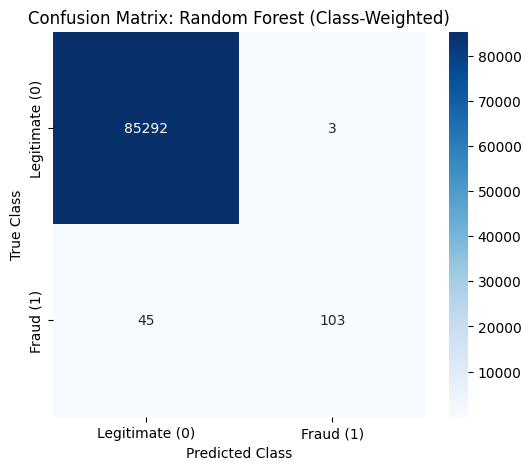

In [17]:
# --- New Cell 7: VISUALIZE BEST MODEL PERFORMANCE (RF Class-Weighted) ---

# Get the confusion matrix data from the best model (Cell 5 output)
cm = confusion_matrix(y_test, y_pred_RF_weighted)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Legitimate (0)', 'Fraud (1)'],
    yticklabels=['Legitimate (0)', 'Fraud (1)']
)
plt.title('Confusion Matrix: Random Forest (Class-Weighted)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Focus the discussion on the top-right (False Positives) and bottom-left (False Negatives) cells.